
# 2.2-kW induction motor

This example simulates observer-based V/Hz control of a 2.2-kW induction motor
drive.


In [1]:
pip install motulator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 3.8 MB/s eta 0:00:00


In [2]:
import numpy as np

from motulator.drive import model
import motulator.drive.control.im as control
from motulator.drive.utils import (
    BaseValues, InductionMachinePars, InductionMachineInvGammaPars,
    NominalValues, plot, Sequence)

Compute base values based on the nominal values (just for figures).



In [3]:
nom = NominalValues(U=400, I=5, f=50, P=2.2e3, tau=14.6)
base = BaseValues.from_nominal(nom, n_p=2)

Configure the system model.



In [4]:
# Configure the induction machine using its inverse-Γ parameters
mdl_ig_par = InductionMachineInvGammaPars(
    n_p=2, R_s=3.7, R_R=2.1, L_sgm=.021, L_M=.224)
mdl_par = InductionMachinePars.from_inv_gamma_model_pars(mdl_ig_par)
machine = model.InductionMachine(mdl_par)
mechanics = model.StiffMechanicalSystem(J=.015)
converter = model.VoltageSourceConverter(u_dc=540)
mdl = model.Drive(converter, machine, mechanics)

Configure the control system.



In [5]:
# Inverse-Γ model parameter estimates
par = mdl_ig_par  # Assume accurate machine model parameter estimates
cfg = control.ObserverBasedVHzControlCfg(
    nom_psi_s=base.psi, max_i_s=1.5*base.i, slip_compensation=False)
ctrl = control.ObserverBasedVHzControl(par, cfg, T_s=250e-6)

Set the speed reference.



In [6]:
# Speed reference
times = np.array([0, .125, .25, .375, .5, .625, .75, .875, 1])*4
values = np.array([0, 0, 1, 1, 0, -1, -1, 0, 0])*base.w
ctrl.ref.w_m = Sequence(times, values)

Set the load torque reference.



In [7]:
# External load torque
times = np.array([0, .125, .125, .875, .875, 1])*4
values = np.array([0, 0, 1, 1, 0, 0])*nom.tau
mdl.mechanics.tau_L = Sequence(times, values)

Create the simulation object and simulate it.



In [8]:
sim = model.Simulation(mdl, ctrl)
sim.simulate(t_stop=4)

Plot results in per-unit values. By omitting the argument `base` you can plot
the results in SI units.



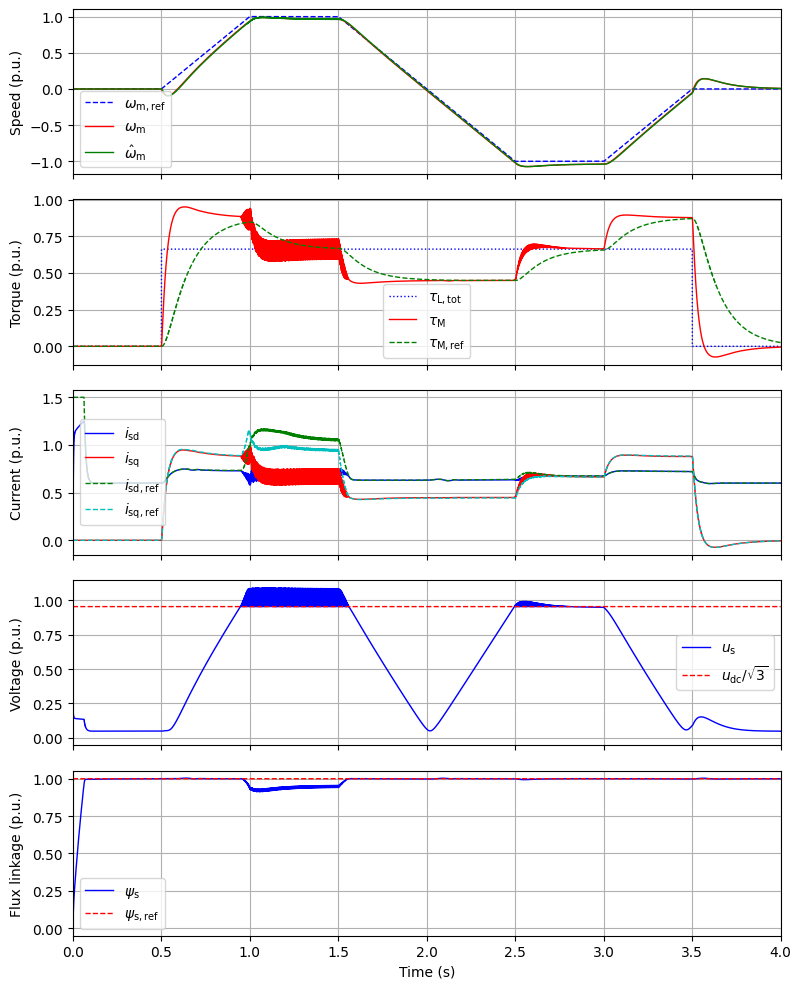

In [9]:
plot(sim, base)